In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('HD142527A_ATV.csv')
data = data[data.index != 2]
data = data[data.index != 6]
data[np.isnan(data)==True] = 0
data['Star ratio'] = data['Line Counts']/data['Cont Counts']
data

,Epoch,Line Counts,Cont Counts,Scale,Total int (min),Exposure (sec),Line Ghost Counts,Line BKA,Line BKA err,Companion Cont Alpha,Cont Alpha err,Star ratio
0,56393,282080.0,3.267880e+05,0.9,74.191167,2.27,1554.5,58.249847,5.312587,0.0,0.0,0.863190
1,56755,568561.0,5.064620e+05,1.2,51.000000,45.00,2995.0,43.998208,11.731801,0.0,0.0,1.122613
3,57157,488362.0,4.290620e+05,1.2,90.308167,2.27,2628.0,64.610126,8.243337,0.0,0.0,1.138208
4,57158,1027017.0,9.287127e+05,1.2,43.243500,2.27,5773.0,39.175037,12.768668,0.0,0.0,1.105850
5,57160,16683996.0,1.013874e+07,1.8,79.500000,30.00,93783.0,47.516873,6.459086,0.0,0.0,1.645568
7,58235,969732.9,8.096610e+05,1.3,48.333333,5.00,5451.0,49.941582,13.012786,0.0,0.0,1.197702


In [39]:
line_ghost_to_star = 185.25
line_g_t_s_err = 14.58
counts_err_est = 60

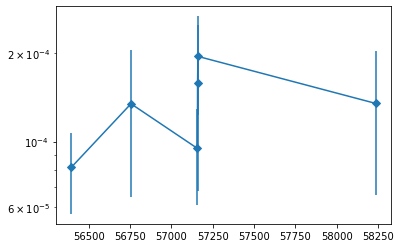

In [40]:
x = data['Epoch']

pcounts = data['Line Ghost Counts']/data['Line BKA'] # try peak instead 
dpcounts = np.sqrt((counts_err_est/data['Line Ghost Counts'])**2 + (data['Line BKA err']/data['Line BKA']))*pcounts

pflux = pcounts/data['Exposure (sec)']
dpf = dpcounts/data['Exposure (sec)']

sflux = data['Line Counts']/data['Exposure (sec)']
dsf = counts_err_est/data['Exposure (sec)']

contrast = pflux/sflux
dcont = np.sqrt((dsf/sflux)**2 + (dpf/pflux)**2)*contrast
y = contrast*data['Star ratio']
dy = dcont*data['Star ratio']


# y = np.log10(y)
# dy = 0.434*(dy/y)
# dy = abs(dy)

plt.errorbar(x=x, y=y, yerr=dy, marker='D')#, ls='none')
plt.yscale('log')
#plt.ylim(15, 9)

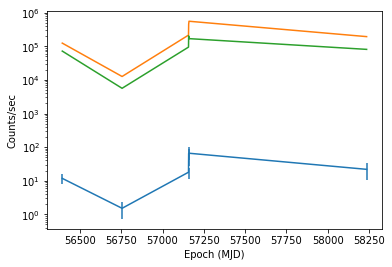

In [33]:
plt.errorbar(x, pflux, yerr=dpf)
plt.errorbar(x, sflux, yerr=dsf)
plt.errorbar(x, 0.5*data['Cont Counts']/data['Exposure (sec)'], yerr=dsf)
plt.yscale('log')
plt.ylabel('Counts/sec')
plt.xlabel('Epoch (MJD)')
plt.savefig('counts_lc.png', transparent=True)

Text(0, 0.5, 'Counts/sec')

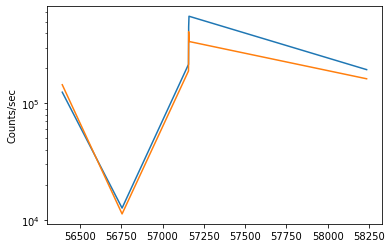

In [34]:
plt.plot(data.Epoch, sflux)
plt.plot(data.Epoch, data['Cont Counts']/data['Exposure (sec)'])
plt.yscale('log')
plt.ylabel('Counts/sec')

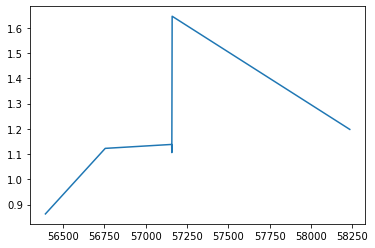

In [35]:
plt.plot(data.Epoch, sflux/(data['Cont Counts']/data['Exposure (sec)']))